# Forecasting Walmart sales using Machine learning methods

### Methods and models used in the solution:
* Random Forest for feature selection
* GridSearchCV for hyperparameters tuning 
* CatBoost for prediction 
* XGBoost for prediction
* TimeSeriesSplit for cross-calidation of Time Series

### Implementation of cross-validation of Time Series

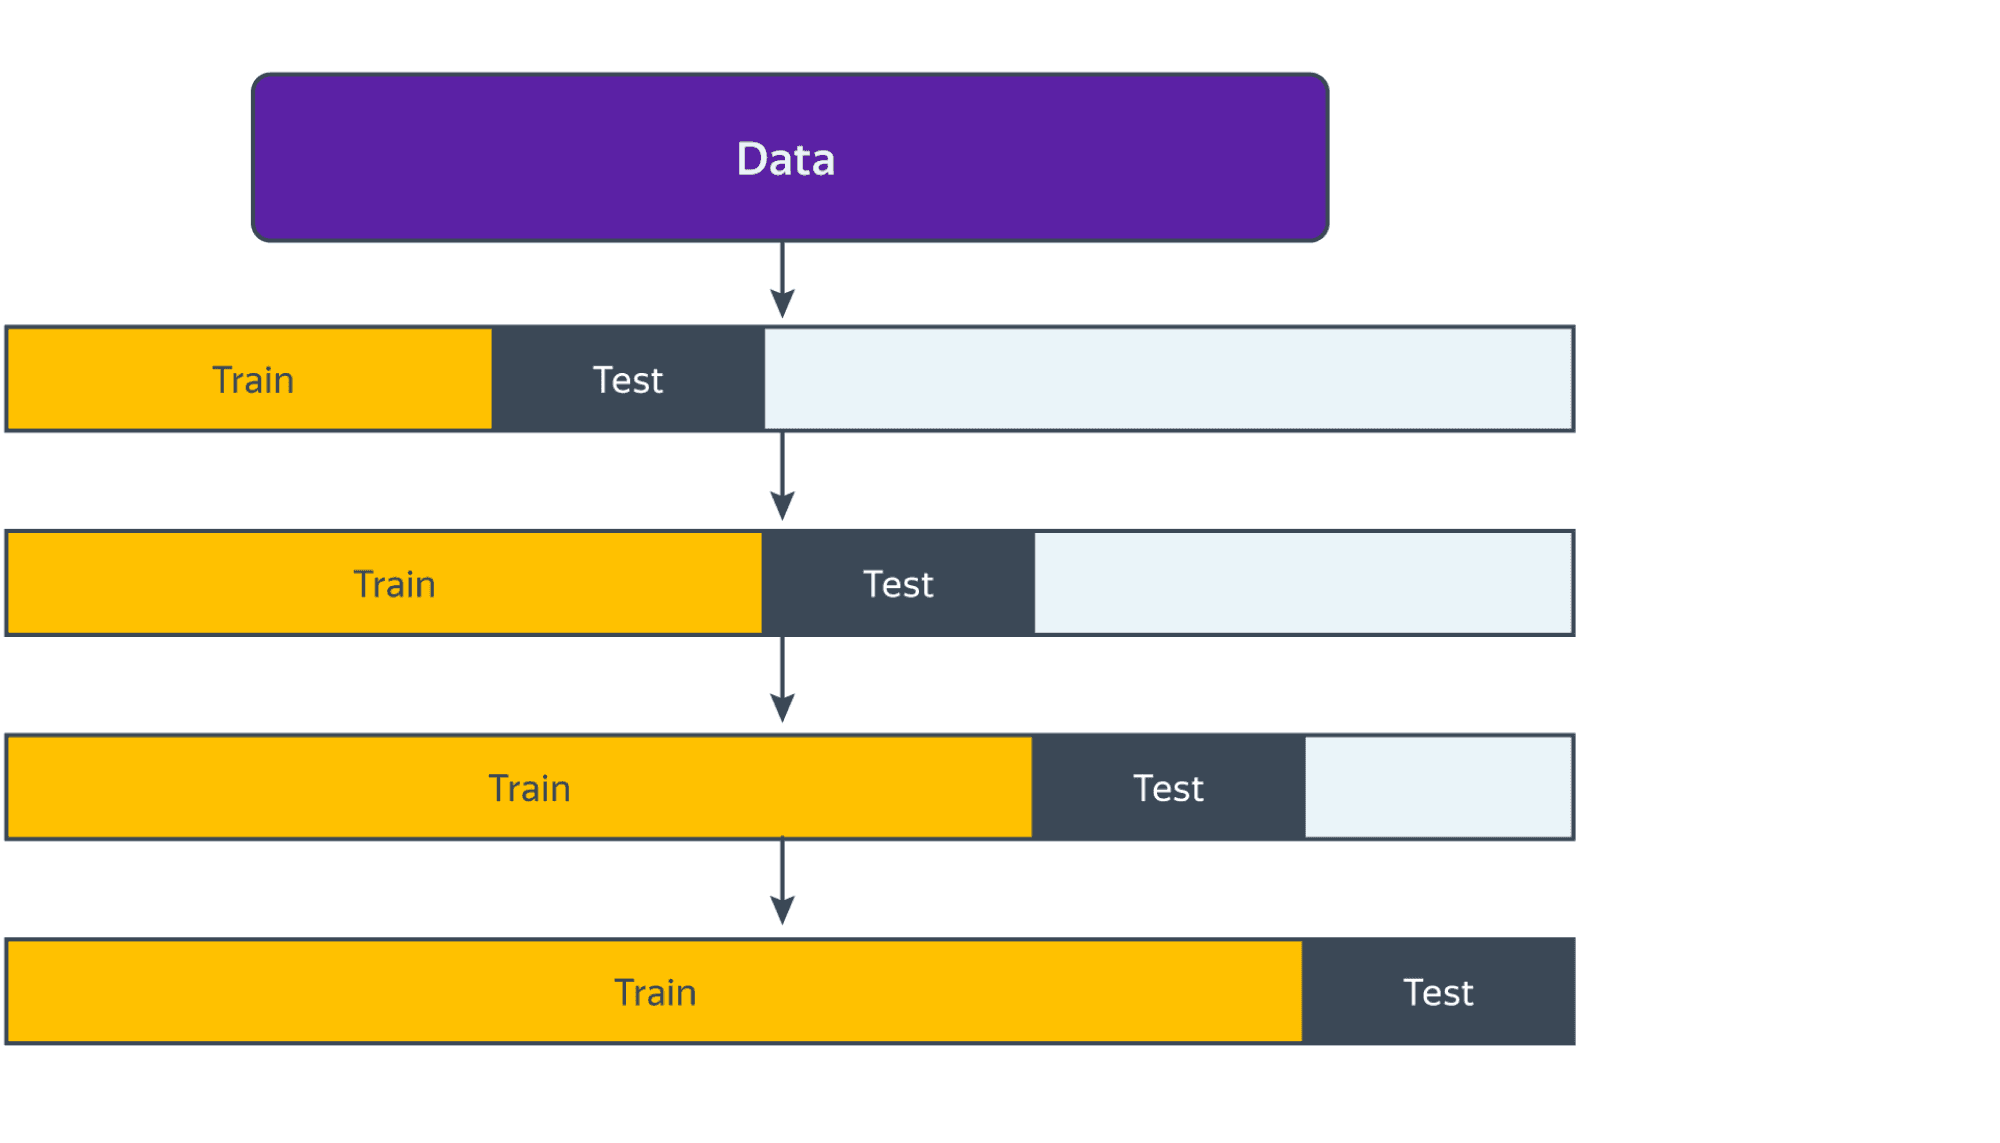

#### Source: https://education.yandex.ru/handbook/ml/article/kross-validaciya


### Machine learning is one of the best methods for predicting time sequences and now I will test it in practice. I’ll prepare the data, train using Random Forest to select features, and only then start training using XGBoost and CatBoost, while using GridSearchCV to select hyperparameters

In [21]:
import pandas as pd 

train = pd.read_csv(r'C:\Users\Shant\OneDrive\Рабочий стол/train.csv')
stores = pd.read_csv(r'C:\Users\Shant\OneDrive\Рабочий стол/stores.csv')
features = pd.read_csv(r'C:\Users\Shant\OneDrive\Рабочий стол/features.csv')

### Import libraries

In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.model_selection import train_test_split 

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [23]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [24]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [25]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


**Combine all datasets into one table**

In [26]:
data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
data.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

### Checking for passes

In [28]:
data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64

### Processing passes

In [29]:
data['MarkDown1'].fillna(value=0,inplace=True)
data['MarkDown2'].fillna(value=0,inplace=True)
data['MarkDown3'].fillna(value=0,inplace=True)
data['MarkDown4'].fillna(value=0,inplace=True)
data['MarkDown5'].fillna(value=0,inplace=True)

### Removing an extra column

In [30]:
data.drop(['IsHoliday_y'], axis=1,inplace=True)

In [31]:
data.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [32]:
data.shape

(421570, 16)

## Exploratory Data Analysis

In [33]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,421570.0,2590.074819,6052.385934,0.000,0.000000,0.00000,2809.050000,88646.760000
MarkDown2,421570.0,879.974298,5084.538801,-265.760,0.000000,0.00000,2.200000,104519.540000
MarkDown3,421570.0,468.087665,5528.873453,-29.100,0.000000,0.00000,4.540000,141630.610000
MarkDown4,421570.0,1083.132268,3894.529945,0.000,0.000000,0.00000,425.290000,67474.850000
MarkDown5,421570.0,1662.772385,4207.629321,0.000,0.000000,0.00000,2168.040000,108519.280000


In [34]:
import plotly.express as px


data.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
Store,421570.000000,22.200546,12.785297,1.000000,11.000000,22.000000,33.000000,45.000000
Dept,421570.000000,44.260317,30.492054,1.000000,18.000000,37.000000,74.000000,99.000000
Weekly_Sales,421570.000000,15981.258123,22711.183519,-4988.940000,2079.650000,7612.030000,20205.852500,693099.360000
Temperature,421570.000000,60.090059,18.447931,-2.060000,46.680000,62.090000,74.280000,100.140000
Fuel_Price,421570.000000,3.361027,0.458515,2.472000,2.933000,3.452000,3.738000,4.468000
MarkDown1,421570.000000,2590.074819,6052.385934,0.000000,0.000000,0.000000,2809.050000,88646.760000
MarkDown2,421570.000000,879.974298,5084.538801,-265.760000,0.000000,0.000000,2.200000,104519.540000
MarkDown3,421570.000000,468.087665,5528.873453,-29.100000,0.000000,0.000000,4.540000,141630.610000
MarkDown4,421570.000000,1083.132268,3894.529945,0.000000,0.000000,0.000000,425.290000,67474.850000
MarkDown5,421570.000000,1662.772385,4207.629321,0.000000,0.000000,0.000000,2168.040000,108519.280000


In [35]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(data).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,min,max,mean
Store,int64,0,0.000000,45,421570,1.000000,45.000000,22.200546
Dept,int64,0,0.000000,81,421570,1.000000,99.000000,44.260317
Date,object,0,0.000000,143,421570,nan,nan,nan
Weekly_Sales,float64,0,0.000000,359464,421570,-4988.940000,693099.360000,15981.258123
IsHoliday,bool,0,0.000000,2,421570,nan,nan,nan
Temperature,float64,0,0.000000,3528,421570,-2.060000,100.140000,60.090059
Fuel_Price,float64,0,0.000000,892,421570,2.472000,4.468000,3.361027
MarkDown1,float64,0,0.000000,2278,421570,0.000000,88646.760000,2590.074819
MarkDown2,float64,0,0.000000,1499,421570,-265.760000,104519.540000,879.974298
MarkDown3,float64,0,0.000000,1662,421570,-29.100000,141630.610000,468.087665


Store


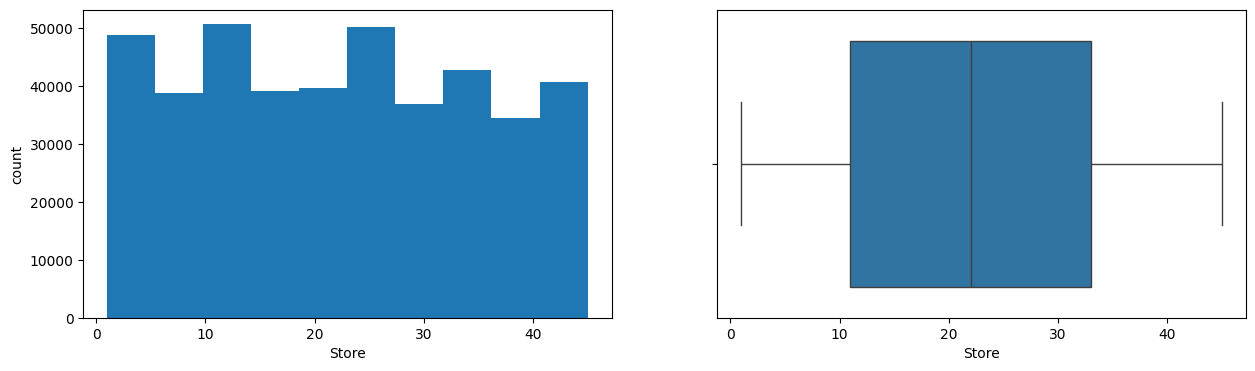

Dept


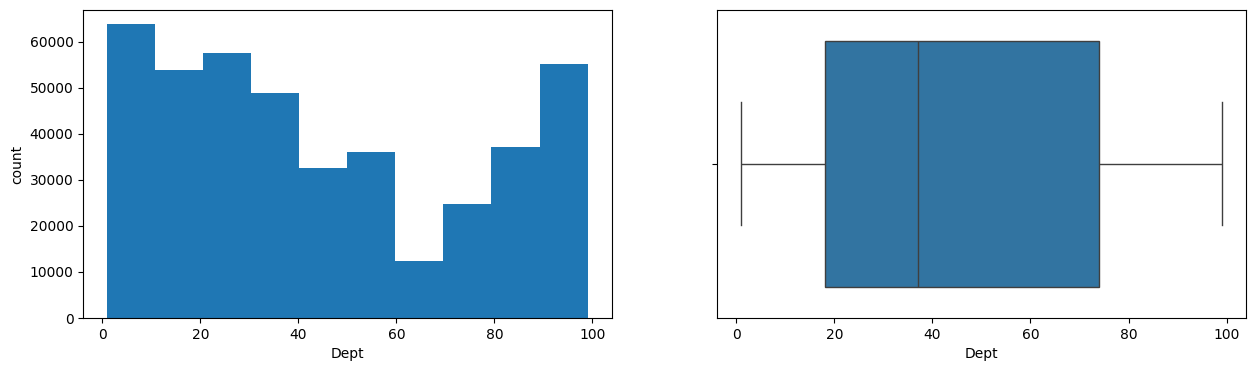

Weekly_Sales


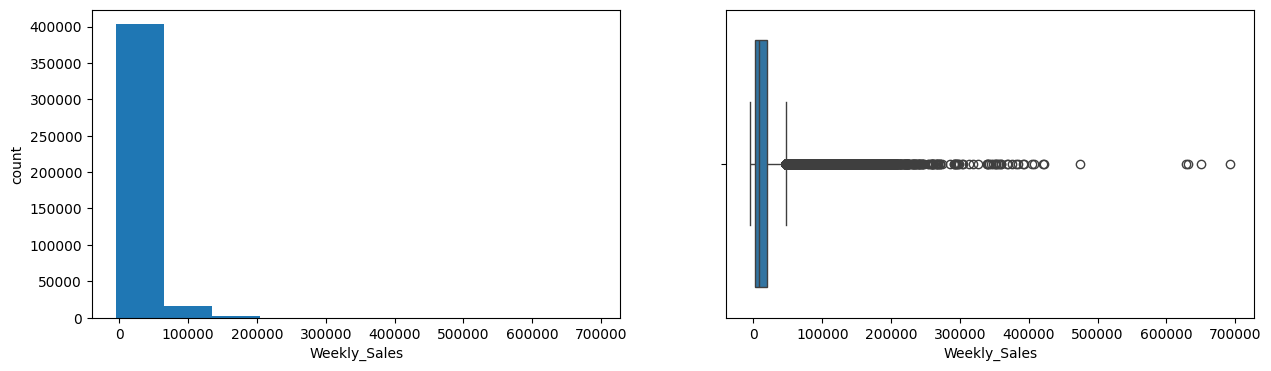

Temperature


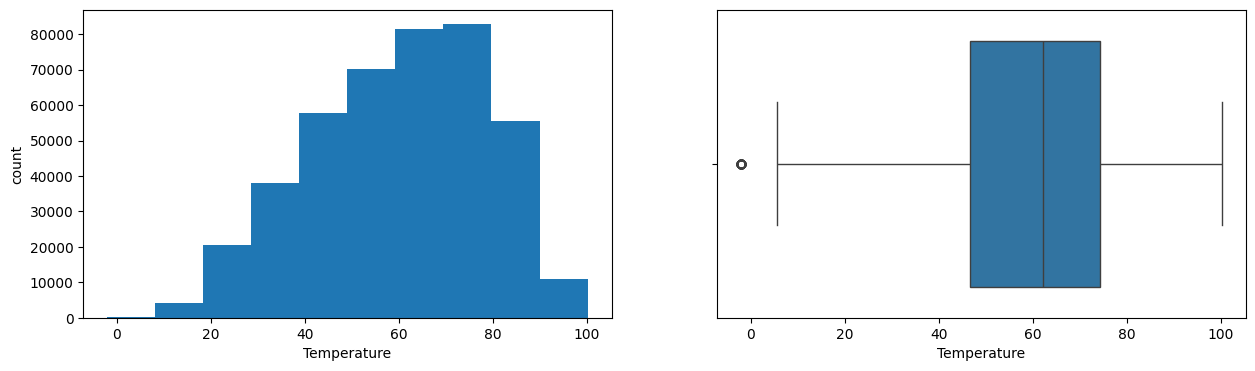

Fuel_Price


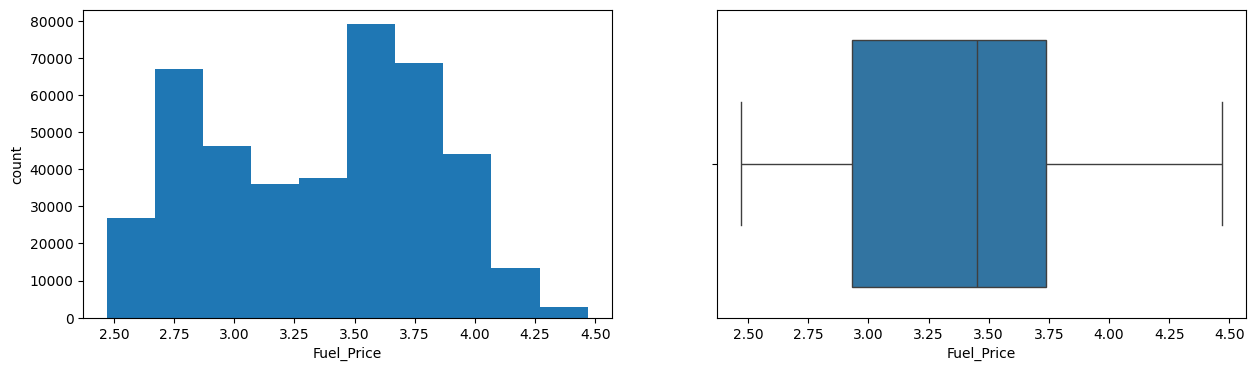

MarkDown1


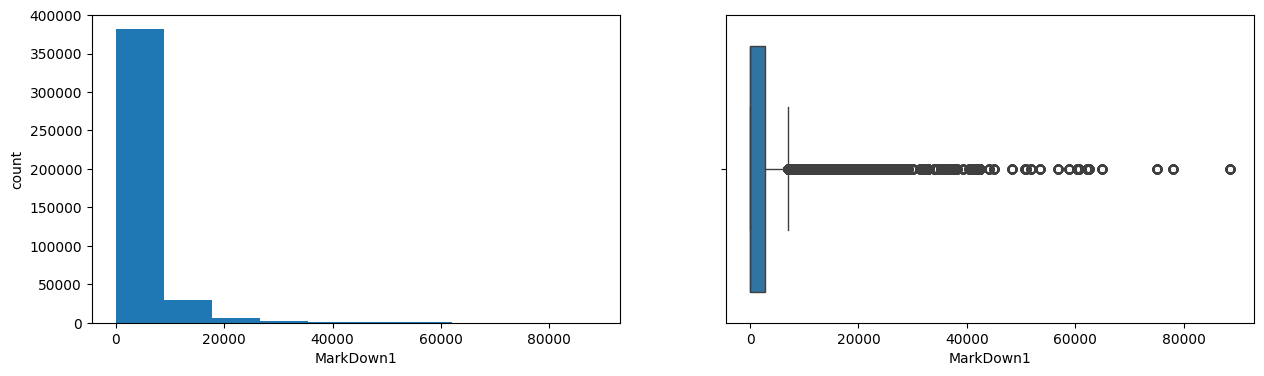

MarkDown2


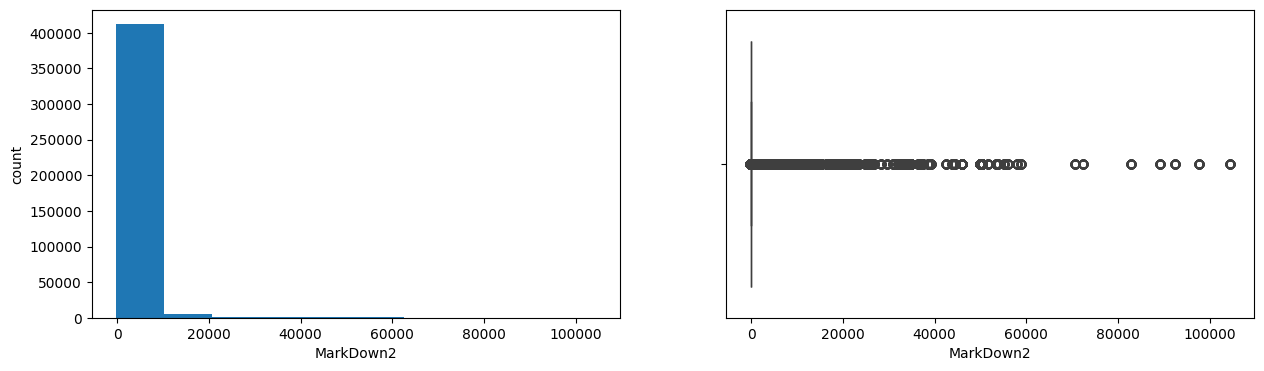

MarkDown3


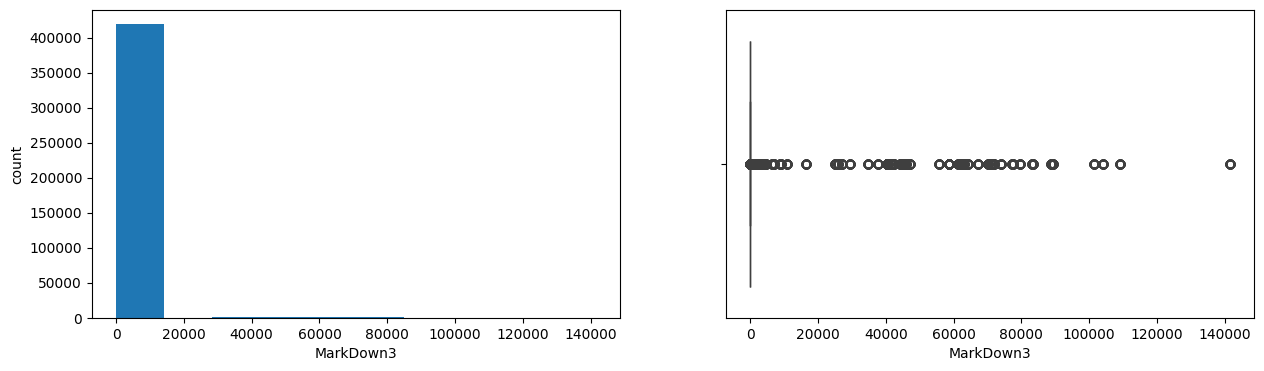

MarkDown4


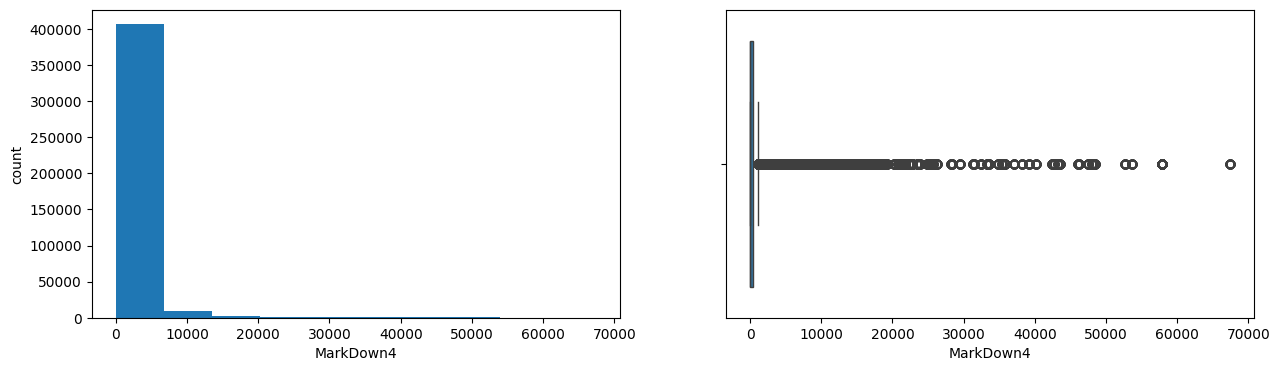

MarkDown5


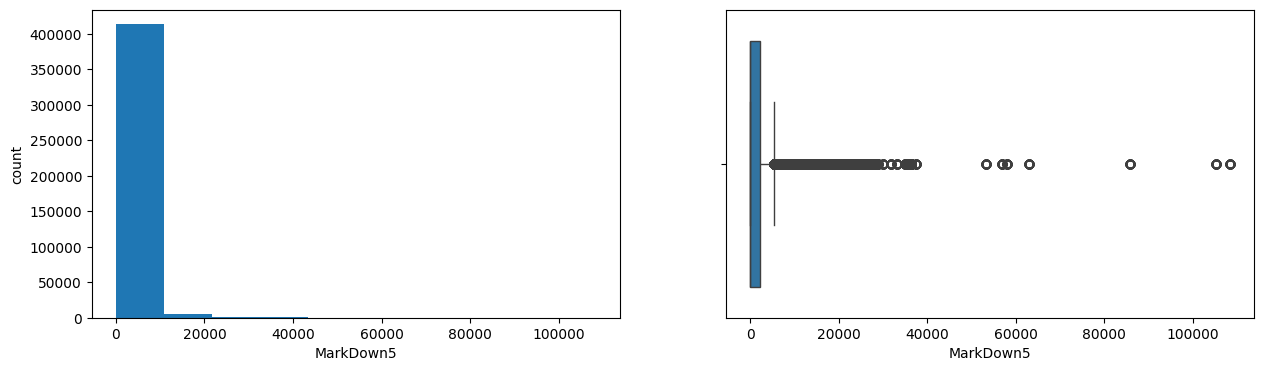

CPI


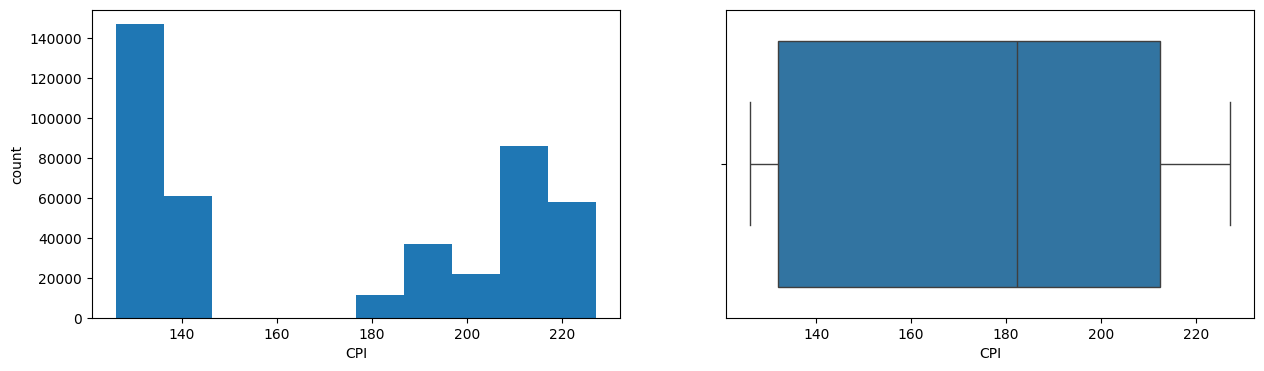

Unemployment


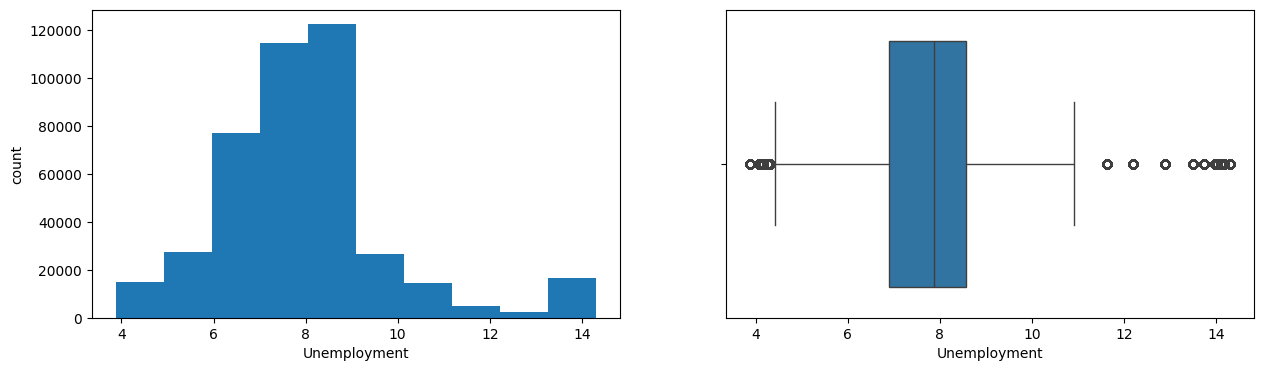

Size


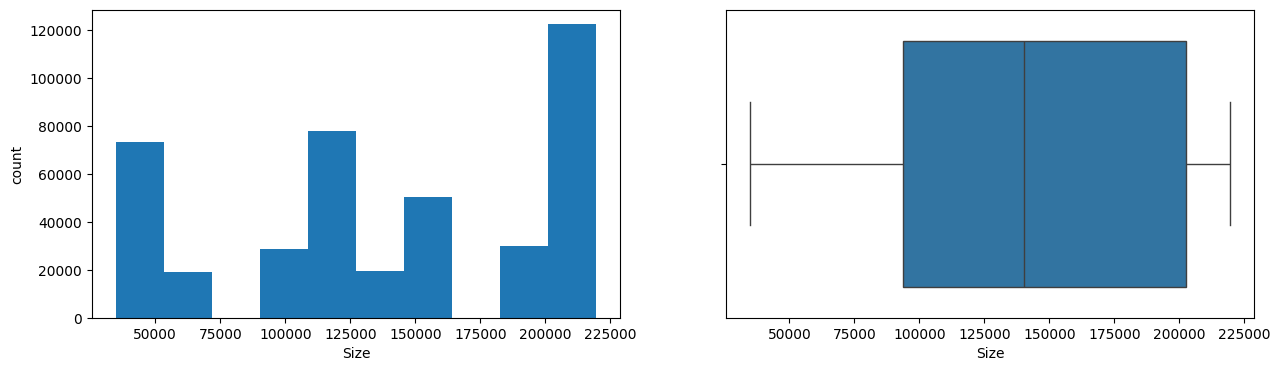

In [27]:
num_cols = data.select_dtypes(include=['int', 'float64']).copy()
num_cols = num_cols.columns

for col in num_cols:
    print(col)
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    data[col].hist(grid=False)
    plt.ylabel('count')
    plt.xlabel(col)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

Text(0.5, 1.0, 'Weekly Sales')

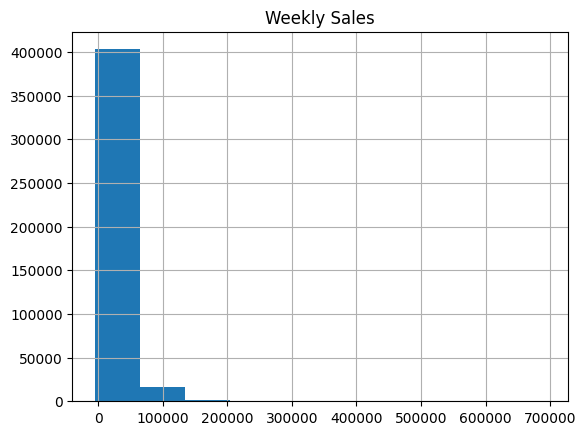

In [281]:
data['Weekly_Sales'].hist()
plt.title('Weekly Sales') 

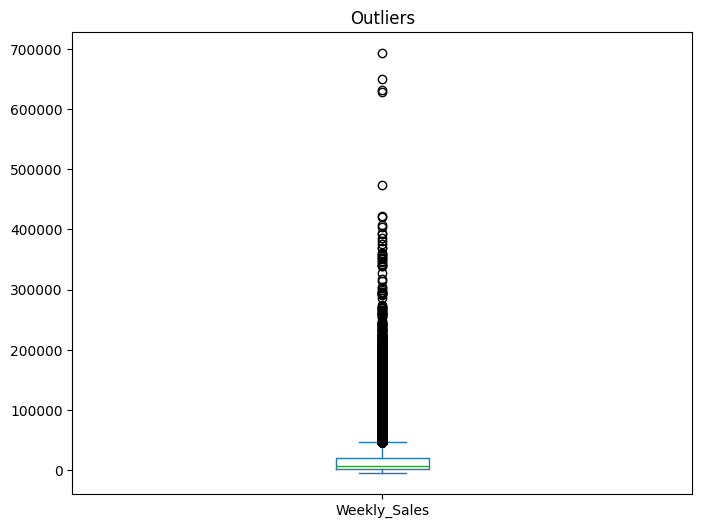

In [282]:
plt.figure(figsize=(8,6))
data['Weekly_Sales'].plot(kind='box')
plt.title('Outliers')
plt.show()

### Remove outliers in the target variable

In [283]:
data = data[data['Weekly_Sales'] < 100000] 

Text(0.5, 1.0, 'Weekly Sales')

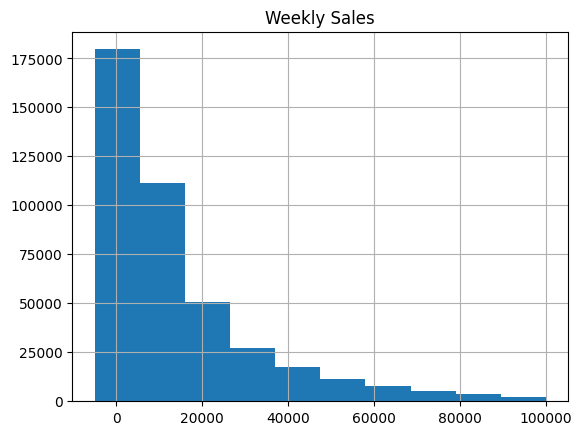

In [284]:
data['Weekly_Sales'].hist()
plt.title('Weekly Sales')

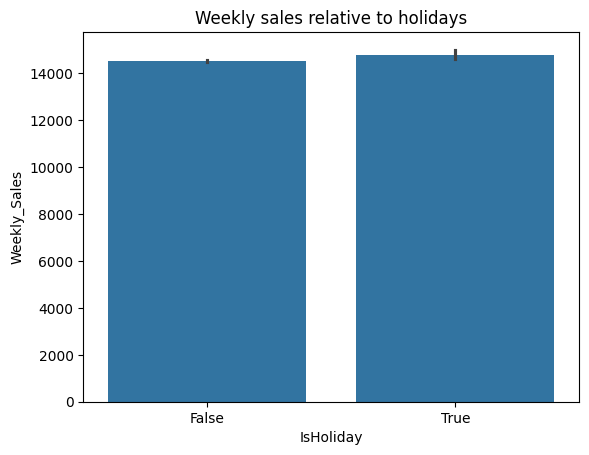

In [285]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=data)
plt.title('Weekly sales relative to holidays')
plt.show()

### Pull out the dates of important holidays from the Date column and write them in our table

In [286]:
data_holiday = data.loc[data['IsHoliday']==True]
data_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [287]:
data_not_holiday = data.loc[data['IsHoliday']==False]
data_not_holiday['Date'].nunique() 

133

In [288]:
data.loc[(data['Date'] == '2010-02-12')|(data['Date'] == '2011-02-11')|(data['Date'] == '2012-02-10'),'Super_Bowl'] = True
data.loc[(data['Date'] != '2010-02-12')&(data['Date'] != '2011-02-11')&(data['Date'] != '2012-02-10'),'Super_Bowl'] = False

C:\Users\Shant\AppData\Local\Temp\ipykernel_26216\2622281322.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data['Date'] == '2010-02-12')|(data['Date'] == '2011-02-11')|(data['Date'] == '2012-02-10'),'Super_Bowl'] = True


In [289]:
data.loc[(data['Date'] == '2010-09-10')|(data['Date'] == '2011-09-09')|(data['Date'] == '2012-09-07'),'Labor_Day'] = True
data.loc[(data['Date'] != '2010-09-10')&(data['Date'] != '2011-09-09')&(data['Date'] != '2012-09-07'),'Labor_Day'] = False

C:\Users\Shant\AppData\Local\Temp\ipykernel_26216\2328727954.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data['Date'] == '2010-09-10')|(data['Date'] == '2011-09-09')|(data['Date'] == '2012-09-07'),'Labor_Day'] = True


In [290]:
data.loc[(data['Date'] == '2010-11-26')|(data['Date'] == '2011-11-25'),'Thanksgiving'] = True
data.loc[(data['Date'] != '2010-11-26')&(data['Date'] != '2011-11-25'),'Thanksgiving'] = False

C:\Users\Shant\AppData\Local\Temp\ipykernel_26216\1920065823.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data['Date'] == '2010-11-26')|(data['Date'] == '2011-11-25'),'Thanksgiving'] = True


In [291]:
data.loc[(data['Date'] == '2010-12-31')|(data['Date'] == '2011-12-30'),'Christmas'] = True
data.loc[(data['Date'] != '2010-12-31')&(data['Date'] != '2011-12-30'),'Christmas'] = False

C:\Users\Shant\AppData\Local\Temp\ipykernel_26216\15003962.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data['Date'] == '2010-12-31')|(data['Date'] == '2011-12-30'),'Christmas'] = True


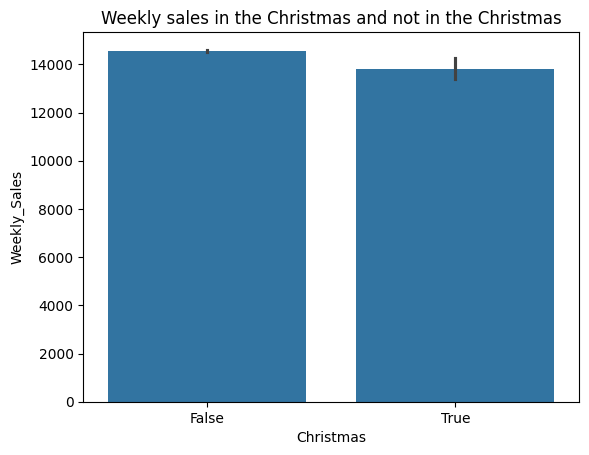

In [292]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=data)
plt.title('Weekly sales in the Christmas and not in the Christmas')
plt.show()

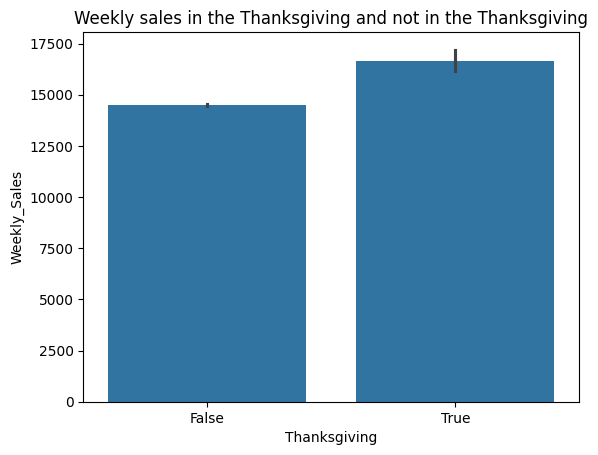

In [293]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=data)
plt.title('Weekly sales in the Thanksgiving and not in the Thanksgiving')
plt.show()

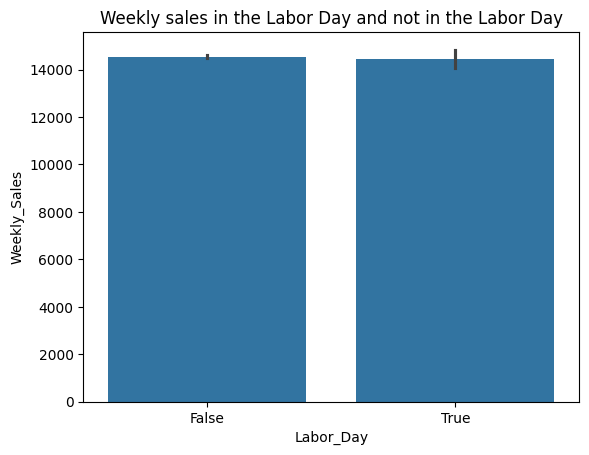

In [294]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=data)
plt.title('Weekly sales in the Labor Day and not in the Labor Day')
plt.show()

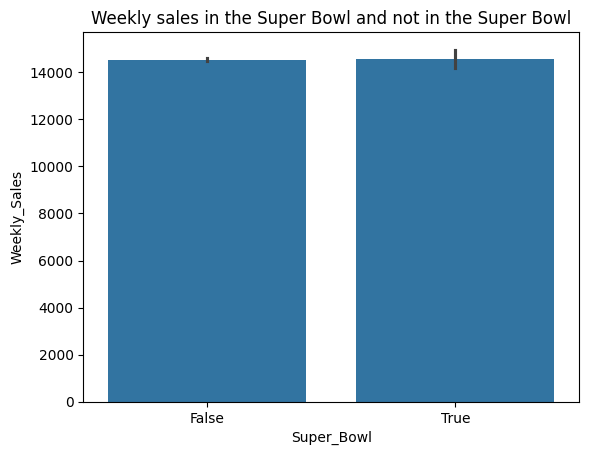

In [295]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=data)
plt.title('Weekly sales in the Super Bowl and not in the Super Bowl')
plt.show()

In [296]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

### Average Monthly Sales

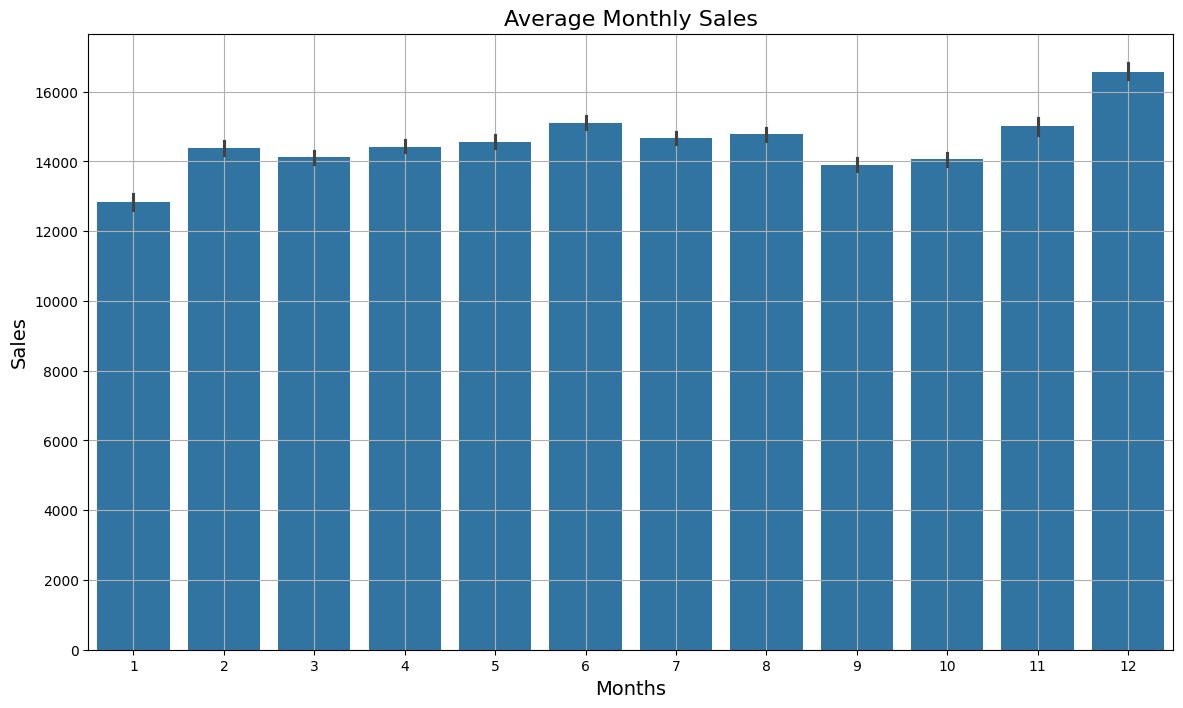

In [297]:
plt.figure(figsize=(14,8))
sns.barplot(x='Month',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Average Monthly Sales',fontsize=16)
plt.grid()

<Axes: xlabel='Month'>

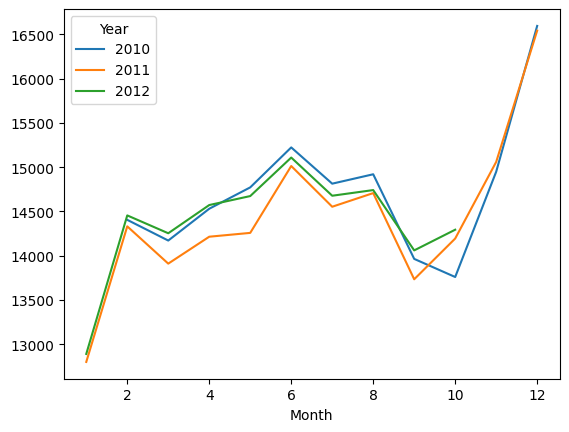

In [298]:
monthly_sales = pd.pivot_table(data, values = "Weekly_Sales", columns = "Year", index = "Month")
monthly_sales.plot()

### Average Year Sales

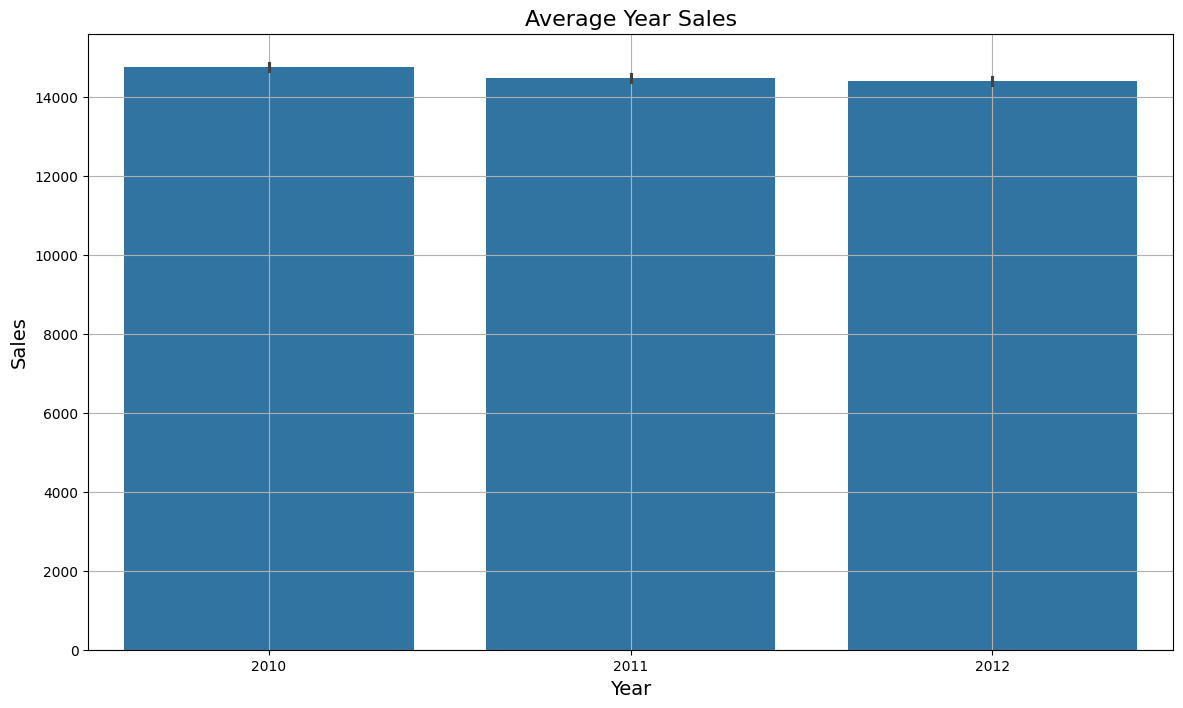

In [299]:
plt.figure(figsize=(14,8))
sns.barplot(x='Year',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.title('Average Year Sales',fontsize=16)
plt.grid()

### Effect of Temperature

C:\Users\Shant\AppData\Local\Temp\ipykernel_26216\2693820973.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Temperature'])


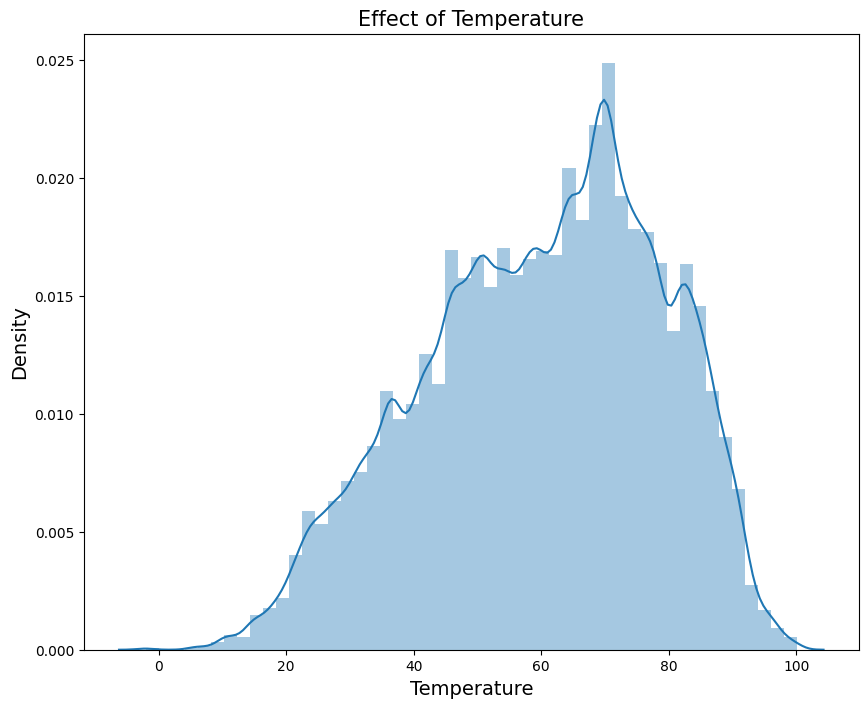

In [300]:
plt.figure(figsize=(10,8))
sns.distplot(data['Temperature'])
plt.title('Effect of Temperature',fontsize=15)
plt.xlabel('Temperature',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.show()

### Look at the correlation of features

In [301]:
data_num = data.select_dtypes(include=['int', 'float64']).copy()

Index(['Store', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Size', 'Year', 'Month'],
      dtype='object')

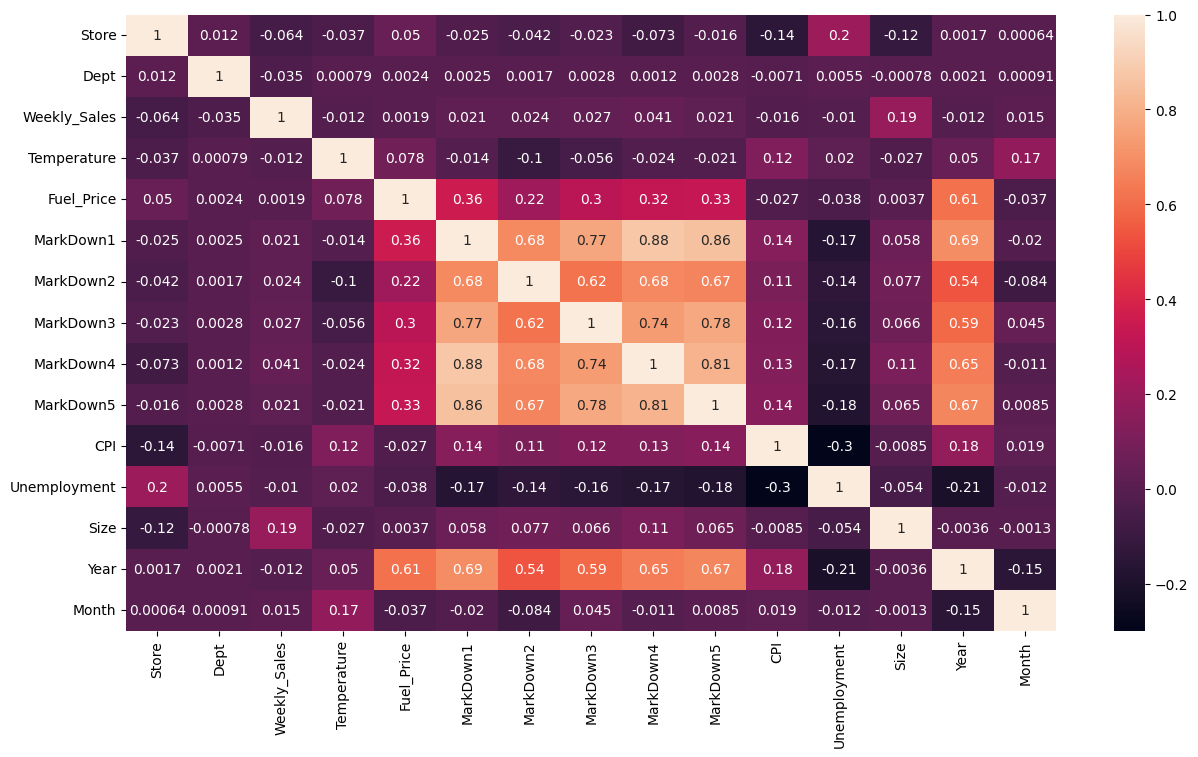

In [302]:
corr = data_num.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
data_num.columns

## Data preprocessing

In [303]:
data_encoded = data.copy()

In [304]:
type_group = {'A':1, 'B': 2, 'C': 3}  
data_encoded['Type'] = data_encoded['Type'].replace(type_group)

In [305]:
data_encoded['Super_Bowl'] = data_encoded['Super_Bowl'].astype(bool).astype(int)

In [306]:
data_encoded['Thanksgiving'] = data_encoded['Thanksgiving'].astype(bool).astype(int)

In [307]:
data_encoded['Labor_Day'] = data_encoded['Labor_Day'].astype(bool).astype(int)

In [308]:
data_encoded['Christmas'] = data_encoded['Christmas'].astype(bool).astype(int)

In [309]:
data_encoded['IsHoliday'] = data_encoded['IsHoliday'].astype(bool).astype(int)

In [310]:
data = data_encoded

In [311]:
data = data.drop('Date', axis=1)

In [312]:
y = data['Weekly_Sales']
data = data.drop('Weekly_Sales', axis=1)

In [313]:
X_train = data[:int(0.7*(len(data)))] 
X_test = data[int(0.7*(len(data))):] 

y_train = y[:int(0.7*(len(data)))] 
y_test = y[int(0.7*(len(data))):] 

## Baseline modeling with RandomForestRegressor

In [314]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)


scaler = RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)


y_pred = pipe.predict(X_train)


y_pred_test = pipe.predict(X_test)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Store'),
  Text(1, 0, 'Dept'),
  Text(2, 0, 'IsHoliday'),
  Text(3, 0, 'Temperature'),
  Text(4, 0, 'Fuel_Price'),
  Text(5, 0, 'MarkDown1'),
  Text(6, 0, 'MarkDown2'),
  Text(7, 0, 'MarkDown3'),
  Text(8, 0, 'MarkDown4'),
  Text(9, 0, 'MarkDown5'),
  Text(10, 0, 'CPI'),
  Text(11, 0, 'Unemployment'),
  Text(12, 0, 'Type'),
  Text(13, 0, 'Size'),
  Text(14, 0, 'Super_Bowl'),
  Text(15, 0, 'Labor_Day'),
  Text(16, 0, 'Thanksgiving'),
  Text(17, 0, 'Christmas'),
  Text(18, 0, 'Year'),
  Text(19, 0, 'Month')])

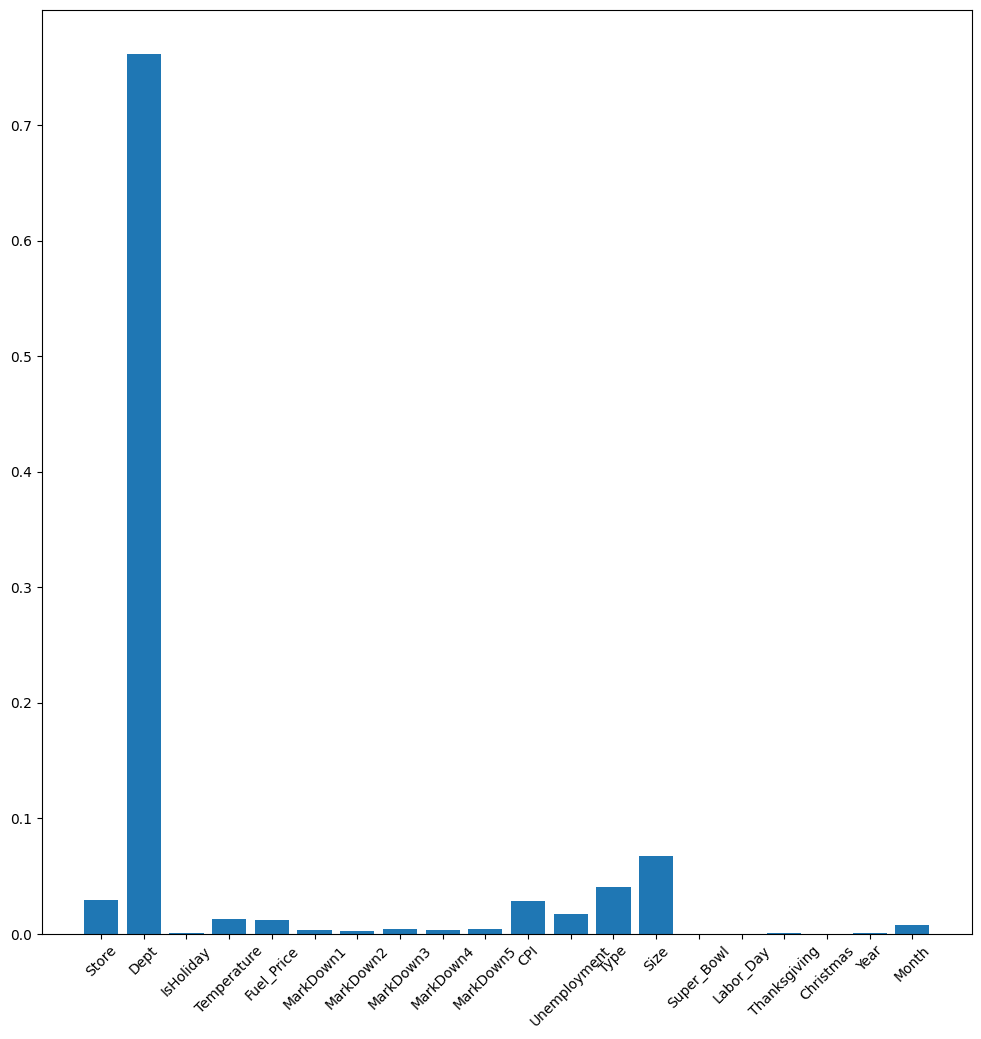

In [315]:
plt.figure(figsize=(12,12))
plt.bar(X_train.columns, rf.feature_importances_)
plt.xticks(rotation=45)

### Our loss function

In [316]:
def wmae_test(test, pred): 
    weights = X1_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

### Results of baseline model 

In [317]:
print('WMAE', wmae_test(y_test, y_pred_test))
print("MAE" , metrics.mean_absolute_error(y_test, y_pred_test))
print("R2" , metrics.explained_variance_score(y_test, y_pred_test))

WMAE 7775.8559972085195
MAE 7658.8515750055885
R2 0.634111337877642


### Remove correlated features and features with small weights

In [318]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment', 'Super_Bowl', 'Labor_Day', 'Thanksgiving','Christmas']
X1_train = X_train.drop(drop_col, axis=1)
X1_test = X_test.drop(drop_col, axis=1)

In [319]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)


y_pred = pipe.predict(X1_train)


y_pred_test = pipe.predict(X1_test)
print('WMAE', wmae_test(y_test, y_pred_test))
print("MAE" , metrics.mean_absolute_error(y_test, y_pred_test))
print("R2" , metrics.explained_variance_score(y_test, y_pred_test))

WMAE 5782.147319557271
MAE 5610.512509389198
R2 0.756188634221755


### With the removal of unnecessary features, the quality of the baseline model has become better, now we use XGBRegressor and CatBoostRegressor 

In [320]:
xgbr = XGBRegressor()
xgbr.fit(X1_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [321]:
y_pred = xgbr.predict(X1_test)

In [328]:
print('WMAE', wmae_test(y_test, y_pred))
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

WMAE 5633.086807053968
MAE 5594.964376501701
R2 0.7007723205619443


### Selecting hyperparameters for CatBoostRegressor using GridSearchCV

In [323]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor 
from sklearn.model_selection import TimeSeriesSplit

parameters = [{
        "n_estimators": [100, 250, 500],
        "random_seed" : [42],
        'learning_rate': [0.01, 0.15],
        "depth" : [5, 8],
        'subsample': [0.6, 0.9],
        "colsample_bylevel": [0.1, 0.5],
        'min_data_in_leaf': [5, 20],
}]


tscv = TimeSeriesSplit(n_splits=4)

grid_cv = GridSearchCV(
    estimator = CatBoostRegressor(
        loss_function = 'RMSE',
        verbose = False),
    param_grid = parameters,
    n_jobs = -1,
    cv = tscv, 
    verbose = 1
)

In [324]:
grid_cv.fit(X1_train, y_train) 

Fitting 4 folds for each of 96 candidates, totalling 384 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001CAC020FF50>,
             n_jobs=-1,
             param_grid=[{'colsample_bylevel': [0.1, 0.5], 'depth': [5, 8],
                          'learning_rate': [0.01, 0.15],
                          'min_data_in_leaf': [5, 20],
                          'n_estimators': [100, 250, 500], 'random_seed': [42],
                          'subsample': [0.6, 0.9]}],
             verbose=1)

In [325]:
grid_cv.best_params_

{'colsample_bylevel': 0.5,
 'depth': 8,
 'learning_rate': 0.15,
 'min_data_in_leaf': 5,
 'n_estimators': 250,
 'random_seed': 42,
 'subsample': 0.9}

In [326]:
y_predict = grid_cv.best_estimator_.predict(X1_test)

In [327]:
print('WMAE', wmae_test(y_test, y_predict))
print("MAE" , metrics.mean_absolute_error(y_test, y_predict))
print("R2" , metrics.explained_variance_score(y_test, y_predict))

WMAE 4770.8704416440005
MAE 4716.269805784319
R2 0.8047324476123998


### To summarize, the machine learning models did not perform well on the data. The error in MAE and WMAE remains large even with the use of gradient boosting.
### This leads us to the conclusion that time Series prediction models are more suitable for predicting sales.